In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel

from quick_downloader import QuickDownloader
from chrome_utils import GrafanaUrlInputs
from processor.load import load_sum_total
from processor.filters import cut_by_window
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from_ts = "2025-08-21 13:36:30"  # Example timestamp
to_ts = "2025-08-21 14:58:30"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perflamd1"
vus = 494
l1 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l1", vus, var_scenario, resource_groups)

from_ts = "2025-08-21 18:00:00"  # Example timestamp
to_ts = "2025-08-22 19:15:00"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perfwamd2"
w2 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l2", vus, var_scenario, resource_groups)

downloader = QuickDownloader([l1, w2])
data_ = downloader.download()

In [3]:
from typing import Callable

def load_request_per_scenario(path: str, rate_columns:tuple[str,...] = ("total",)) -> pd.DataFrame:
    df = load_sum_total(path)
    for col in rate_columns:
        df[f"{col}_rate"] = df[col].diff() / df["dT"]
    return df

def get_os_and_processor(name: str) -> tuple[str, str]:
    os = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os, processor


def merge_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged


total_requests = merge_dashboards(data_, "Total Requests per Scenario", load_request_per_scenario)

In [4]:
# request_duration = merge_dashboards(data_, "Request Duration per Scenario p99", load_sum_total)
# request_duration.drop(columns=["dT"], inplace=True)
# request_duration.columns = [f"{col}_dur" for col in request_duration.columns]
# request_duration.columns

In [5]:
# request_duration

In [6]:
# total_requests

In [7]:
# combined = pd.concat([request_duration, total_requests], axis=1)

In [8]:
# combined.columns

In [9]:
# fig, ax = plt.subplots(figsize=(7.5, 5))
# result_list = []
# for name, group in combined.groupby("instance"):
#     res = group["BAQ"].diff() / group["BAQ_dur"]
#     res = res.dropna()
#     res.plot(use_index=True, label=name, ax=ax)
#     df = pd.DataFrame({
#         "BAQ_reqs/sec": res,
#         "instance": name,
#         "vus": group.loc[res.index, "vus"]
#     })
#     result_list.append(df)
# final_df = pd.concat(result_list).reset_index()

In [10]:
# sns.violinplot(final_df.reset_index(), x ="vus", y="BAQ_reqs/sec", hue="instance", split=True, inner='quartile', fill=False)

In [11]:
# final_df.set_index('Time', inplace=True)
#
# framed = cut_by_window(final_df, "20m", "40m")
# fig, ax = plt.subplots(figsize = (7.5,5))
# for name, group in framed.groupby("instance"):
#     group.plot(use_index=True, y="BAQ_reqs/sec", label=name, ax=ax)

<Axes: xlabel='vus', ylabel='total_rate'>

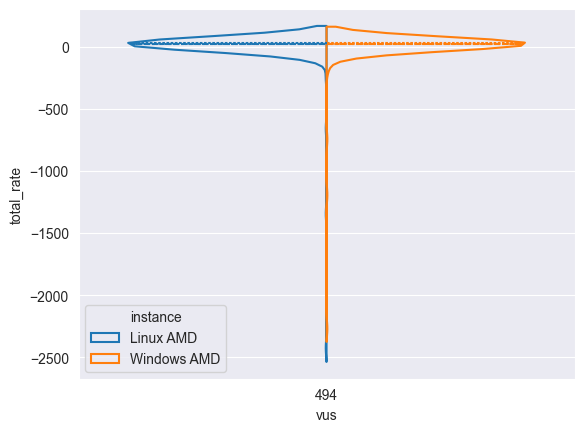

In [12]:
sns.violinplot(total_requests.reset_index(), x ="vus", y="total_rate", hue="instance", split=True, inner='quartile', fill=False)

In [13]:
framed = cut_by_window(total_requests, "20m", "40m")
framed = framed[framed["total_rate"] >= 0]

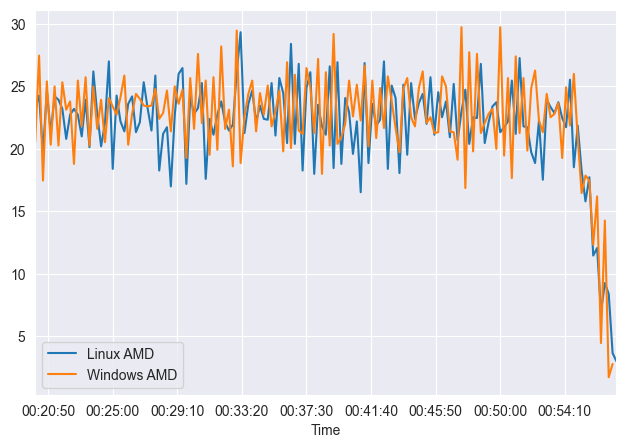

In [14]:
fig, ax = plt.subplots(figsize = (7.5,5))
for name, group in framed.groupby("instance"):
    group.plot(use_index=True, y="total_rate", label=name, ax=ax)

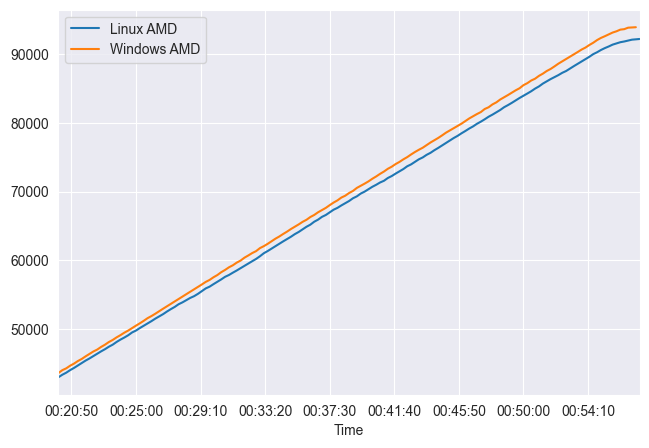

In [15]:
fig, ax = plt.subplots(figsize = (7.5,5))
for name, group in framed.groupby("instance"):
    group.plot(use_index=True, y="total", label=name, ax=ax)

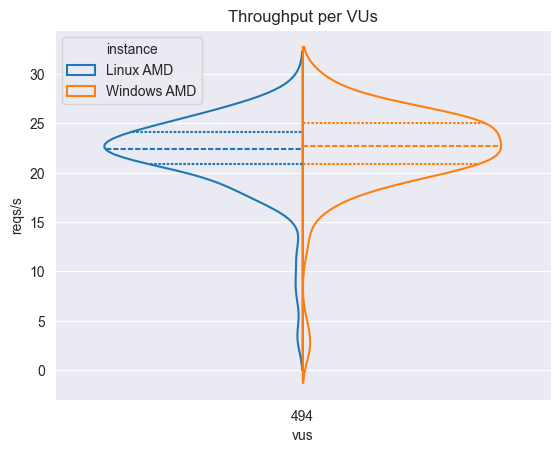

In [16]:
sns.violinplot(framed.reset_index(), x ="vus", y="total_rate", hue="instance", split=True, inner='quartile', fill=False)
plt.title("Throughput per VUs")
plt.ylabel("reqs/s")
plt.show()

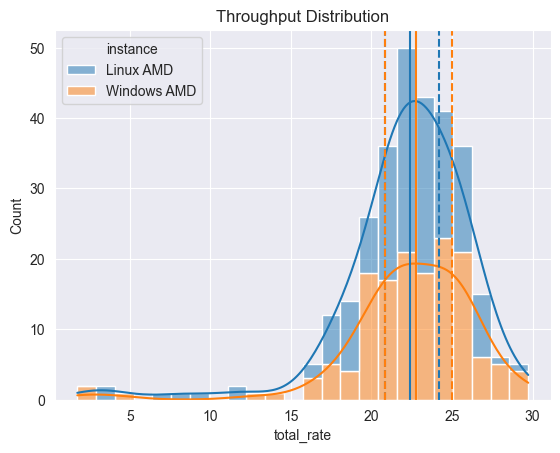

In [17]:
instances = framed["instance"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

sns.histplot(framed.reset_index(), x="total_rate", hue="instance", kde=True, multiple="stack", palette=palette)
percentiles = [25, 50, 75]
for name, group in framed.groupby("instance"):
    for p in percentiles:
        value = np.percentile(group["total_rate"], p)
        linestyle = "-" if p == 50 else "--"
        plt.axvline(value, linestyle=linestyle, label=f"{name} {p}th pct", color=palette[name])

plt.title("Throughput Distribution")
# plt.legend()
plt.show()

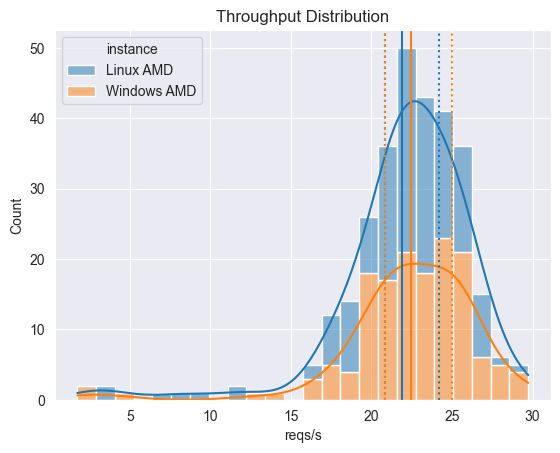

In [18]:
instances = framed["instance"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

sns.histplot(framed.reset_index(), x="total_rate", hue="instance", kde=True, multiple="stack", palette=palette)
for name, group in framed.groupby("instance"):
    median = group["total_rate"].median()

    mean = group["total_rate"].mean()
    std = group["total_rate"].std()

    # plt.axvline(median, color=palette[name], linestyle="--", label=f"{name} median")
    plt.axvline(mean, color=palette[name], linestyle="-", label=f"{name} median")
    p25 = np.percentile(group["total_rate"], 25)
    p75 = np.percentile(group["total_rate"], 75)
    # plt.axvspan(p25, p75, color=palette[name], alpha=0.2, label=f"IQR")
    plt.axvline(p25, color=palette[name], linestyle=":", label=f"{name} 25th pct")
    plt.axvline(p75, color=palette[name], linestyle=":", label=f"{name} 75th pct")

    # # Optionally, show ±1 std deviation
    # plt.axvline(mean-std, color=palette[name], linestyle="-.", label=f"{name} mean - 1 std")
    # plt.axvline(mean+std, color=palette[name], linestyle="-.", label=f"{name} mean + 1 std")
    #plt.axvspan(median - std, median + std, color="gray", alpha=0.2, label=f"{name} ±1 std")

plt.title("Throughput Distribution")
plt.xlabel("reqs/s")
# plt.legend()
plt.show()

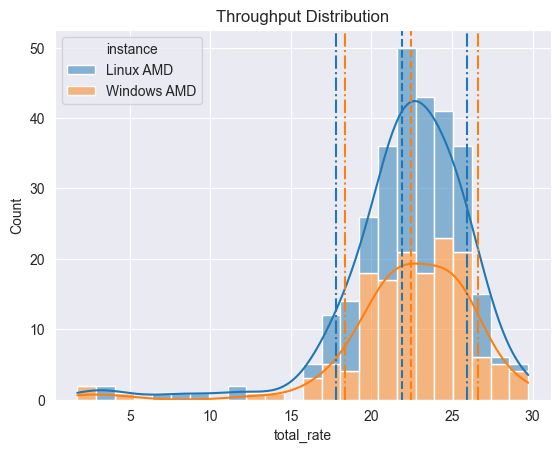

In [19]:
instances = framed["instance"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

sns.histplot(framed.reset_index(), x="total_rate", hue="instance", kde=True, multiple="stack", palette=palette)
for name, group in framed.groupby("instance"):
    # median = group["total_rate"].median()

    mean = group["total_rate"].mean()
    std = group["total_rate"].std()

    plt.axvline(mean, color=palette[name], linestyle="--", label=f"{name} median")
    # p25 = np.percentile(group["total_rate"], 25)
    # p75 = np.percentile(group["total_rate"], 75)
    # # plt.axvspan(p25, p75, color=palette[name], alpha=0.2, label=f"IQR")
    # plt.axvline(p25, color=palette[name], linestyle=":", label=f"{name} 25th pct")
    # plt.axvline(p75, color=palette[name], linestyle=":", label=f"{name} 75th pct")

    # # Optionally, show ±1 std deviation
    plt.axvline(mean-std, color=palette[name], linestyle="-.", label=f"{name} mean - 1 std")
    plt.axvline(mean+std, color=palette[name], linestyle="-.", label=f"{name} mean + 1 std")
    #plt.axvspan(median - std, median + std, color="gray", alpha=0.2, label=f"{name} ±1 std")

plt.title("Throughput Distribution")
# plt.legend()
plt.show()

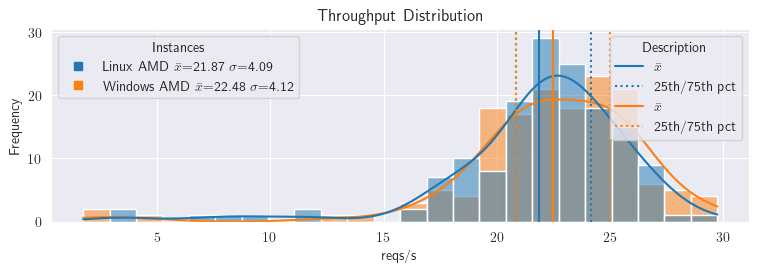

In [20]:
import matplotlib.lines as mlines

plt.rcParams["text.usetex"] = True

fig, ax = plt.subplots(figsize=(9, 2.5))
sns.histplot(framed.reset_index(), x="total_rate", hue="instance", kde=True, palette=palette, ax=ax, multiple="layer")

# Median lines and their handles
line_handles = []
data = {}
for name, group in framed.groupby("instance"):

    mean = group["total_rate"].mean()
    line = ax.axvline(mean, color=palette[name], linestyle="-")
    line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle="-", label=rf"$\bar{{x}}$"))
    std = group["total_rate"].std()

    p25 = np.percentile(group["total_rate"], 25)
    p75 = np.percentile(group["total_rate"], 75)
    # # plt.axvspan(p25, p75, color=palette[name], alpha=0.2, label=f"IQR")
    plt.axvline(p25, color=palette[name], linestyle=":")
    plt.axvline(p75, color=palette[name], linestyle=":")

    line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle=":", label="25th/75th pct"))

    data[name] = {"mean": mean, "std": group["total_rate"].std()}

# Histogram legend (instances)
hist_handles = [
    mlines.Line2D(
        [], [], color=palette[name], marker='s', linestyle='',
        label=rf"{name} $\bar{{x}}$={data[name]['mean']:0.2f} $\sigma$={data[name]['std']:0.2f}"
    )
    for name in instances
]
legend1 = ax.legend(handles=hist_handles, title="Instances", loc="upper left")
ax.add_artist(legend1)

# Median lines legend
ax.legend(handles=line_handles, title="Description", loc="upper right")

plt.title("Throughput Distribution")
plt.xlabel(r"reqs/s")
plt.ylabel("Frequency")
plt.show()

In [21]:
framed.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std',"max"]})

total_rate                   total                       
                  mean       std          mean           std      max
instance                                                             
Linux AMD    21.868433  4.092175  68497.344371  14811.686511  92192.0
Windows AMD  22.482222  4.123264  69534.706667  15080.286589  93902.0

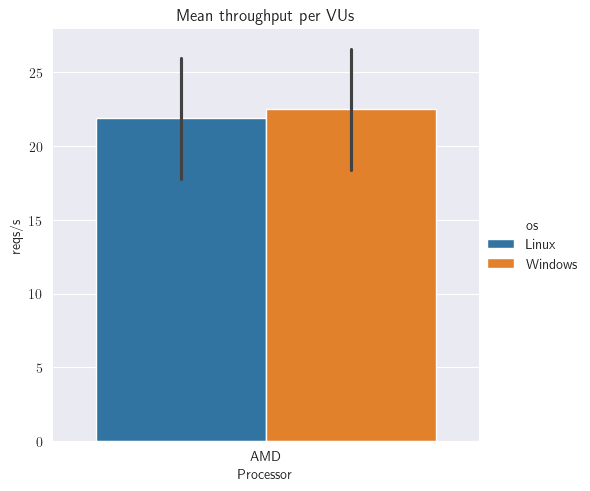

In [22]:
instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

g = sns.catplot(
    data=framed.reset_index(), kind="bar",
    x="processor", y="total_rate", hue="os", row="vus",
    errorbar="sd", palette=palette
)
g.despine(left=True)
g.set_axis_labels("Processor", "reqs/s")
# g.legend.set_title("Instances throughput")
plt.title("Mean throughput per VUs")
plt.show()

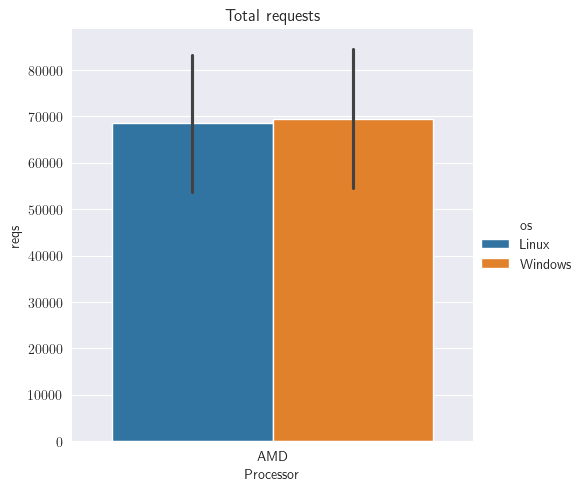

In [23]:
instances = framed["os"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

g = sns.catplot(
    data=framed.reset_index(), kind="bar",
    x="processor", y="total", hue="os", row="vus",
    errorbar="sd", palette=palette
)
g.despine(left=True)
g.set_axis_labels("Processor", "reqs")
# g.legend.set_title("Instances throughput")
plt.title("Total requests")
plt.show()